# Mini Project: American Express_Default Prediction 

In [1]:
#Import required libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amexfeather-data/test_data_f32.ftr
/kaggle/input/amexfeather-data/train_data.ftr
/kaggle/input/amexfeather-data/train_data_f32.ftr
/kaggle/input/amexfeather-data/test_data.ftr
/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr


In [2]:
#Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

#Hyperparameter Tuning
from sklearn.model_selection import KFold

#Model Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Importing data

In [3]:
# Import dataset
train_dataset = pd.read_feather('../input/amexfeather/train_data.ftr')

# Keep the latest statement features for each customer
train_dataset = train_dataset.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

# Data Visualization 

In [4]:
# First 5 rows of the dataset
train_dataset.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0


In [5]:
# Get train set details
train_dataset.info(max_cols=191,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 190 columns):
 #    Column  Non-Null Count   Dtype         
---   ------  --------------   -----         
 0    S_2     458913 non-null  datetime64[ns]
 1    P_2     455944 non-null  float16       
 2    D_39    458913 non-null  float16       
 3    B_1     458913 non-null  float16       
 4    B_2     458882 non-null  float16       
 5    R_1     458913 non-null  float16       
 6    S_3     373943 non-null  float16       
 7    D_41    458882 non-null  float16       
 8    B_3     458882 non-null  float16       
 9    D_42    59910 non-null   float16       
 10   D_43    324591 non-null  float16       
 11   D_44    436618 non-null  float16       
 12   B_4     458913 non-null  float16       
 13   D_45    458882 non-null  float16       
 14   B_5     458913 non-null  float

In [6]:
# Describe train dataset
train_dataset.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,455944.000000,4.589130e+05,458913.000000,4.588820e+05,4.589130e+05,373943.000000,4.588820e+05,4.588820e+05,59910.000000,324591.000000,...,1.639500e+04,1.639500e+04,456083.000000,458913.000000,4.560830e+05,80315.000000,456083.000000,458913.000000,456083.000000,458913.000000
mean,NaN,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.177979,0.000000,...,1.412201e-02,1.589355e-01,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.258934
std,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.253662,0.000000,...,9.527588e-02,2.609863e-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.438050
min,-0.458984,5.960464e-08,-3.570312,1.788139e-07,5.960464e-08,-0.508789,5.960464e-08,5.960464e-08,-0.000240,0.000002,...,3.576279e-07,1.788139e-07,0.000000,0.000000,1.192093e-07,-0.011436,0.000000,0.000000,0.000000,0.000000
25%,0.449219,4.783630e-03,0.008987,7.092285e-02,2.956390e-03,0.127563,3.007889e-03,5.485535e-03,0.031769,0.043335,...,2.519608e-03,3.482819e-03,0.003046,0.002552,3.026962e-03,0.200684,0.003033,0.002758,0.003031,0.000000
50%,0.682617,9.559631e-03,0.033234,8.134766e-01,5.920410e-03,0.164917,6.011963e-03,1.083374e-02,0.108276,0.092407,...,5.050659e-03,7.026672e-03,0.006077,0.005119,6.050110e-03,0.385986,0.006065,0.005501,0.006073,0.000000
75%,0.862305,2.666016e-01,0.153687,1.001953e+00,8.888245e-03,0.264893,8.995056e-03,2.106934e-01,0.230347,0.195068,...,7.579803e-03,5.014648e-01,0.009102,0.007675,9.101868e-03,0.573730,0.009094,0.008255,0.009102,1.000000
max,1.009766,5.000000e+00,1.324219,1.009766e+00,2.759766e+00,3.994141,8.992188e+00,1.596680e+00,4.187500,9.187500,...,1.009766e+00,2.505859e+00,1.009766,1.009766,1.339844e+00,2.228516,1.009766,1.343750,4.828125,1.000000


# Explore categorical and non categorical features

* D_* = Delinquency variables (bad or criminal behaviour, especially among young people)
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables

### categorical

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [7]:
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

numerical_variables = [col for col in train_dataset.columns if col not in categorical_variables + ["target"]]

print(f'Total number of features: {1}')
print(f'Total number of categorical variables: {len(categorical_variables)}')
print(f'Total number of numerical variables: {len(numerical_variables)}')

Total number of features: 1
Total number of categorical variables: 11
Total number of numerical variables: 178


<AxesSubplot:xlabel='target', ylabel='count'>

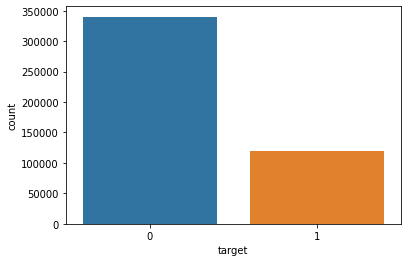

In [8]:
# Visualize the target variable
sns.countplot(x = 'target', data = train_dataset)

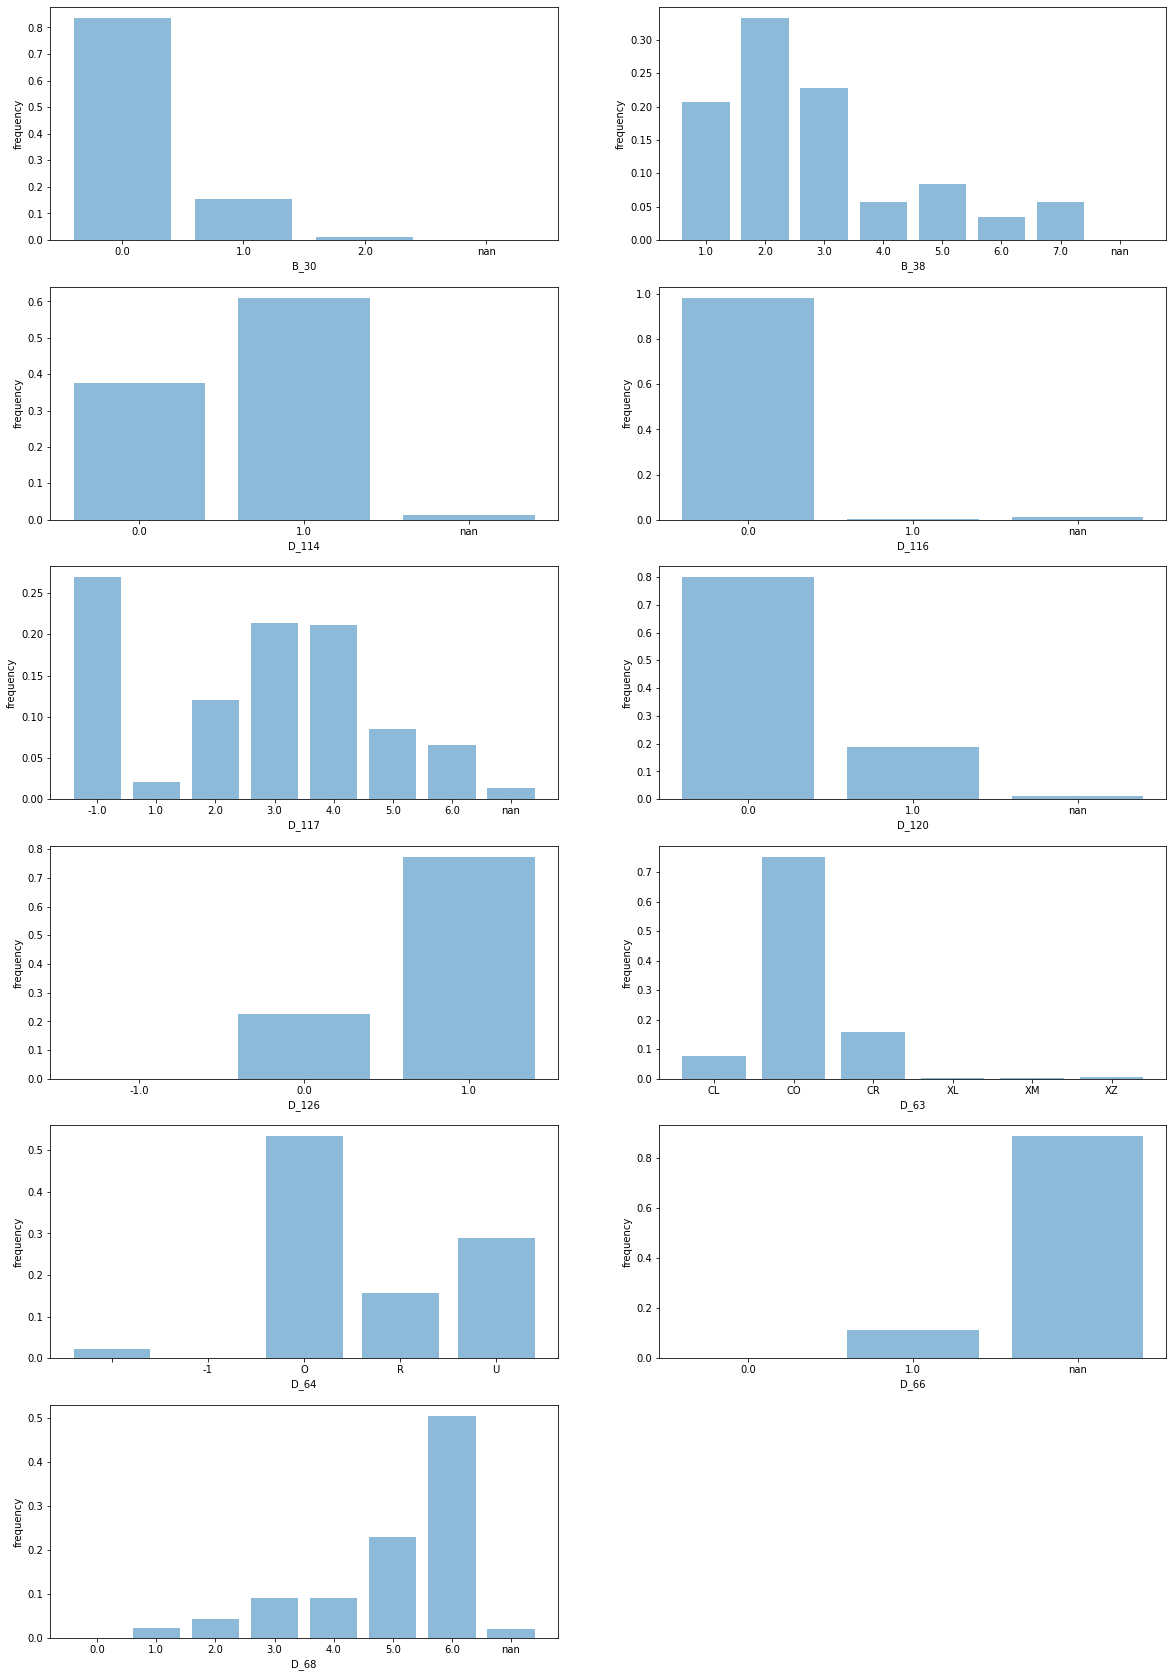

In [9]:
# Visualize categorial features
plt.figure(figsize=(20, 30))
for i, k in enumerate(categorical_variables):
    plt.subplot(6, 2, i+1)
    temp_val = pd.DataFrame(train_dataset[k].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp_val.index.name = 'value'
    temp_val.reset_index(inplace=True)
    plt.bar(temp_val.index, temp_val['count'], alpha=0.5)
    plt.xlabel(k)
    plt.ylabel('frequency')
    plt.xticks(temp_val.index, temp_val.value)
plt.show()

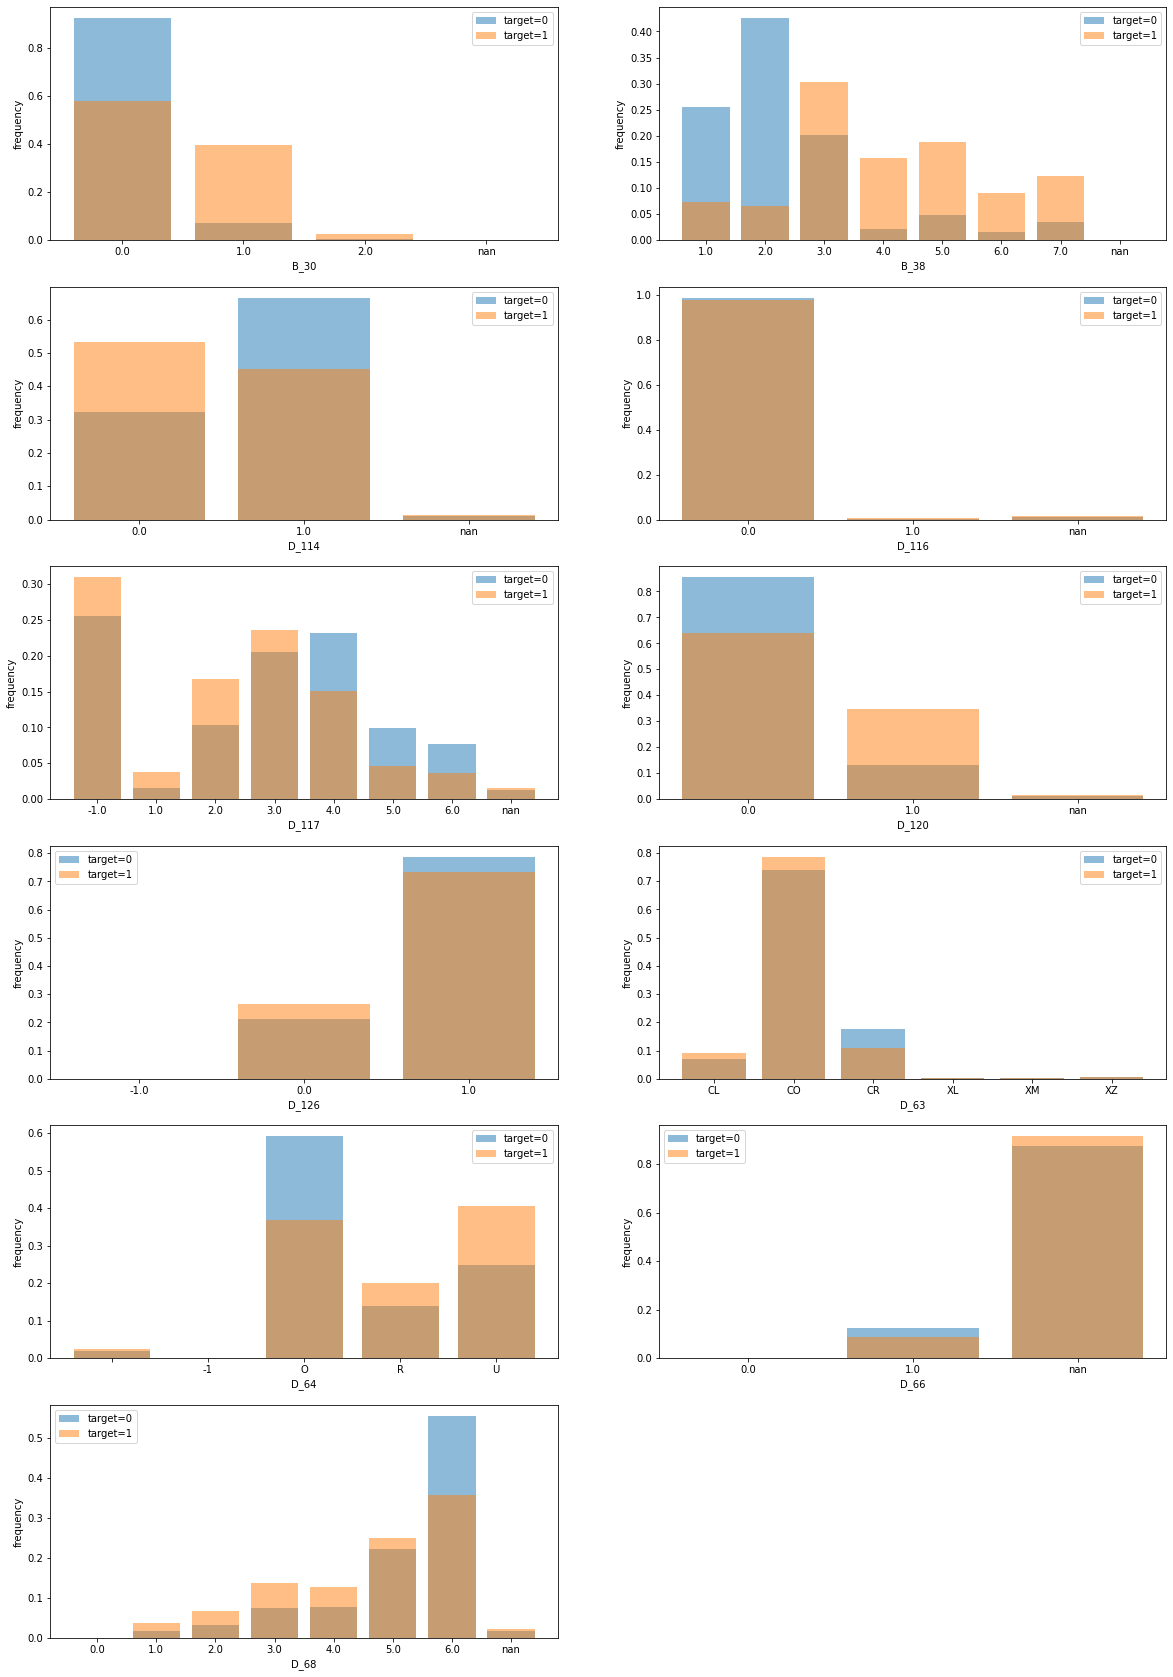

In [10]:
# Visualize categorial features with targets
plt.figure(figsize=(20, 30))
for i, f in enumerate(categorical_variables):
    plt.subplot(6, 2, i+1)
    temp = pd.DataFrame(train_dataset[f][train_dataset.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train_dataset[f][train_dataset.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.show()

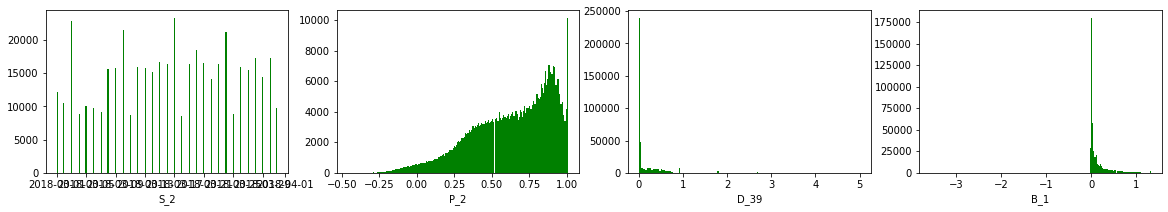

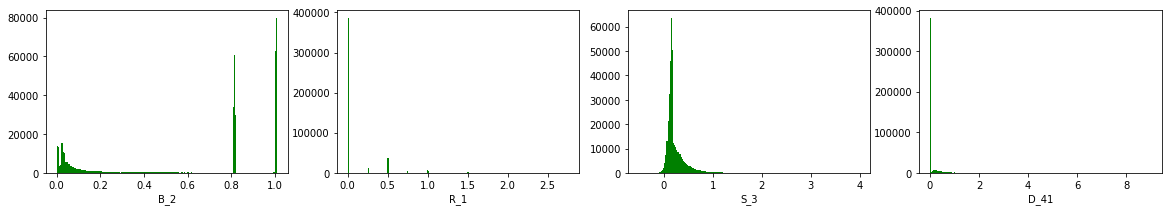

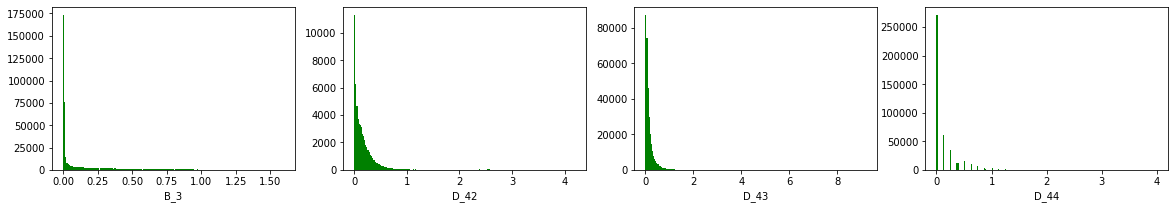

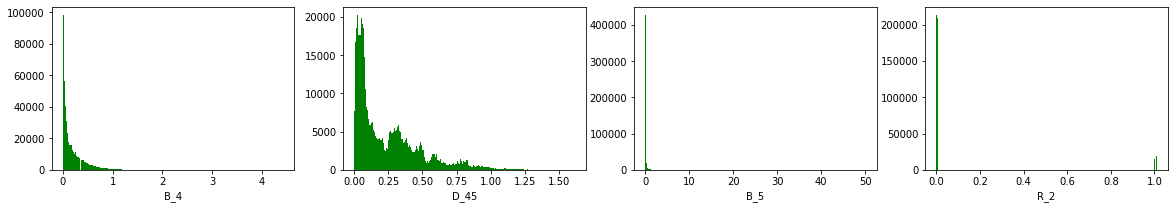

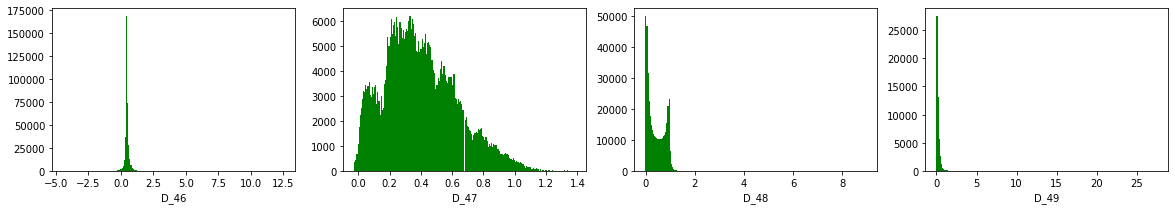

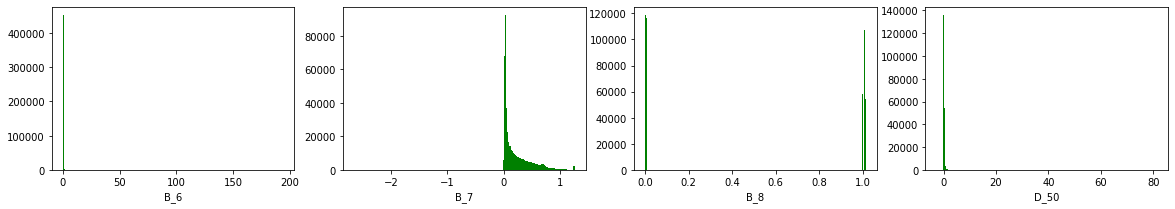

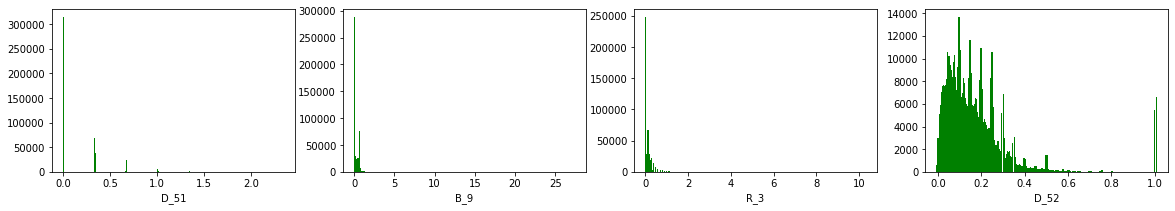

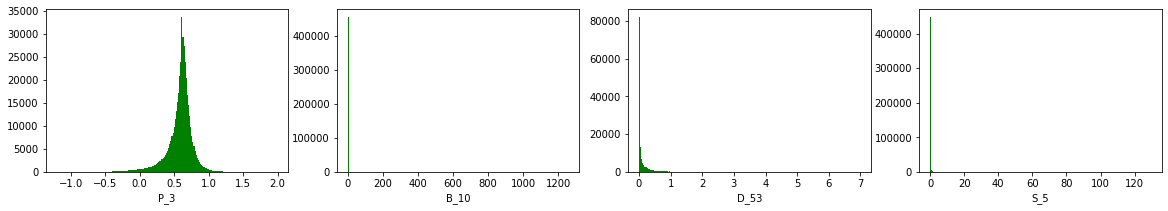

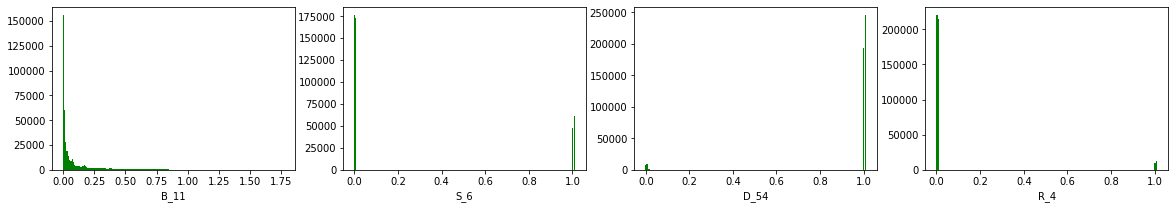

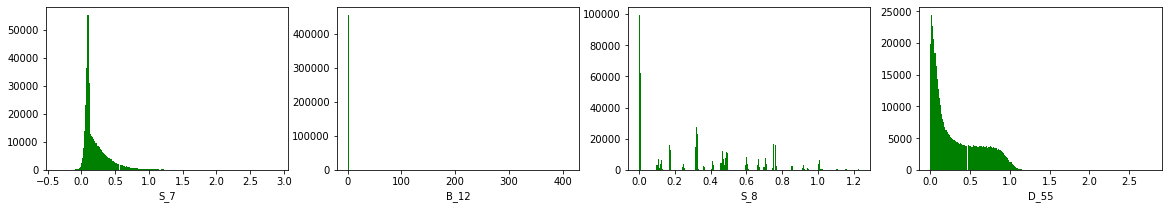

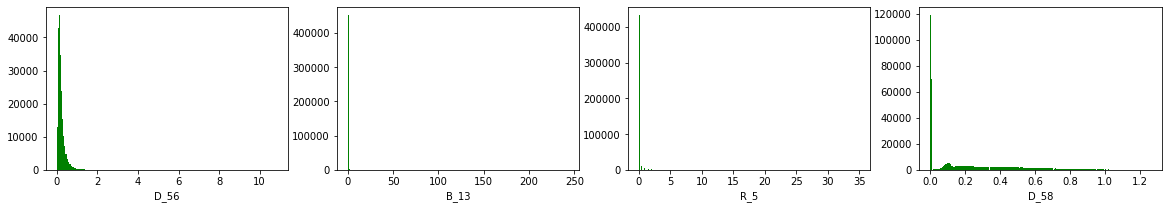

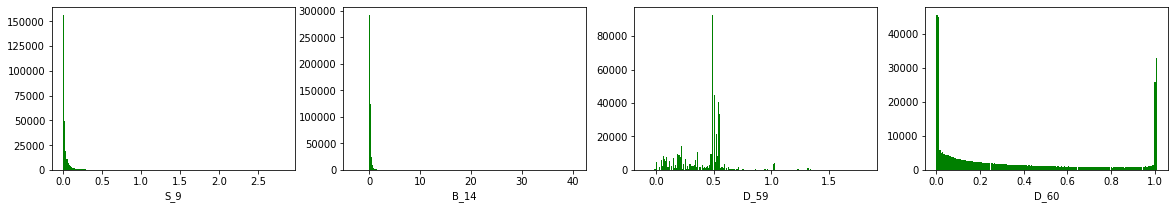

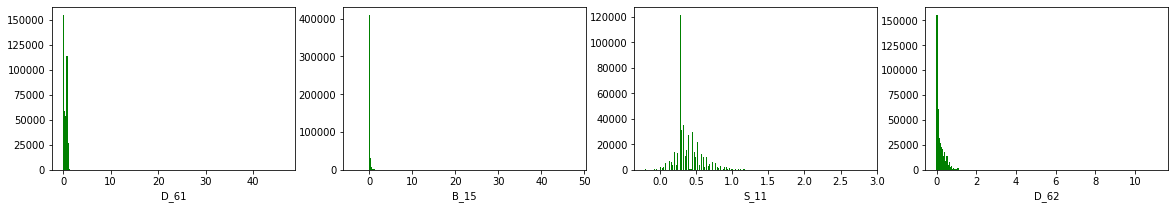

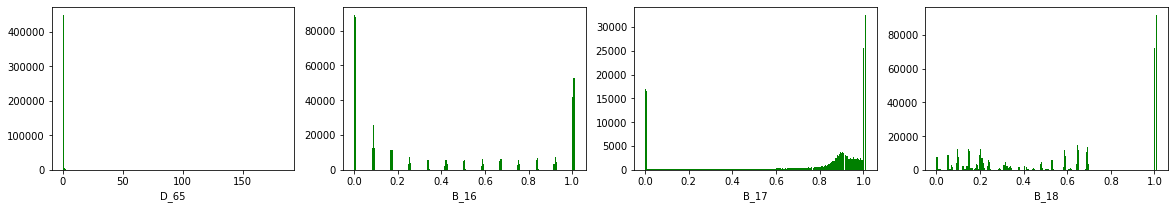

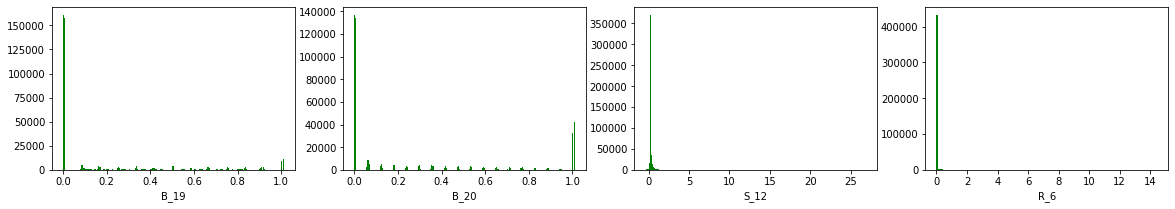

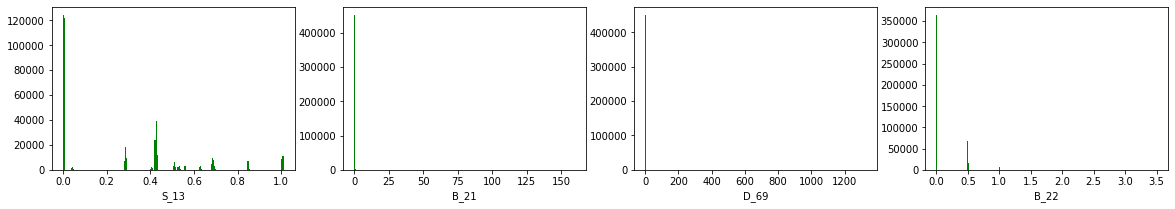

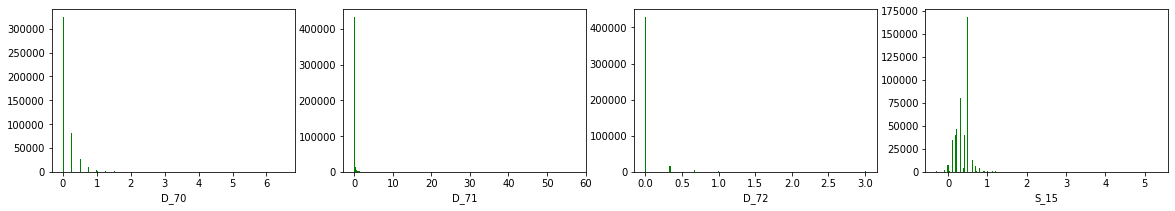

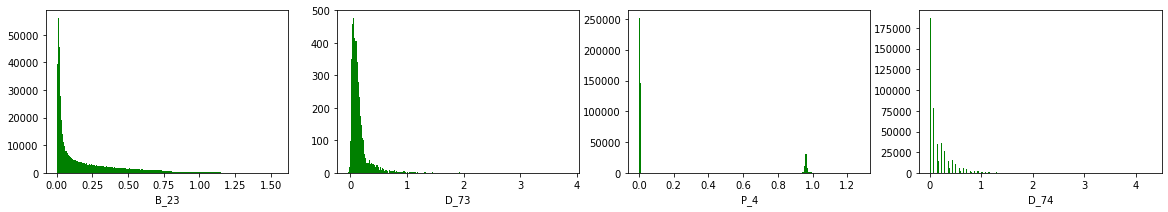

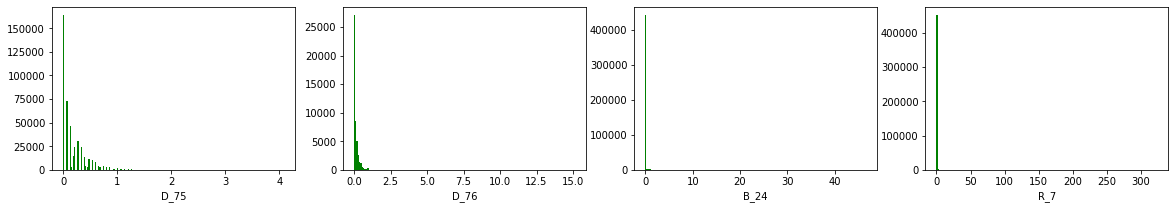

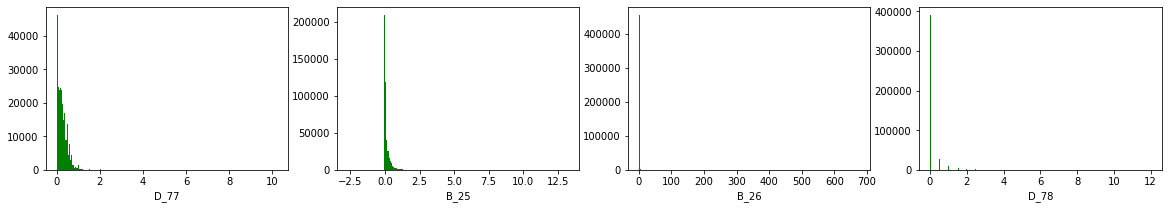

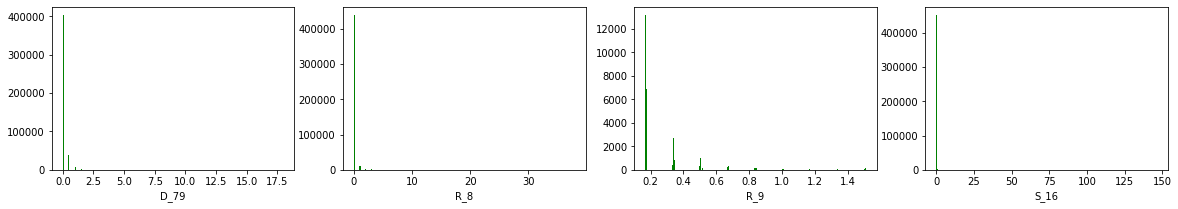

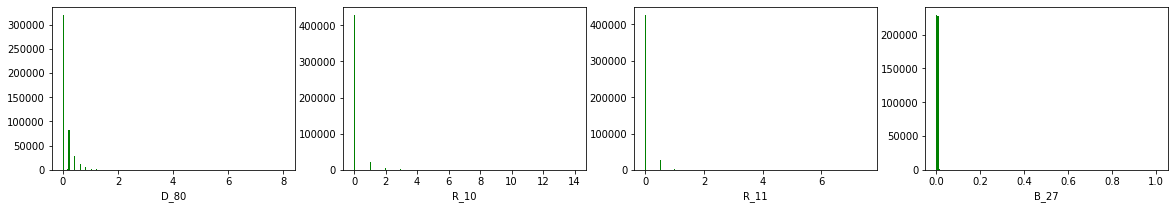

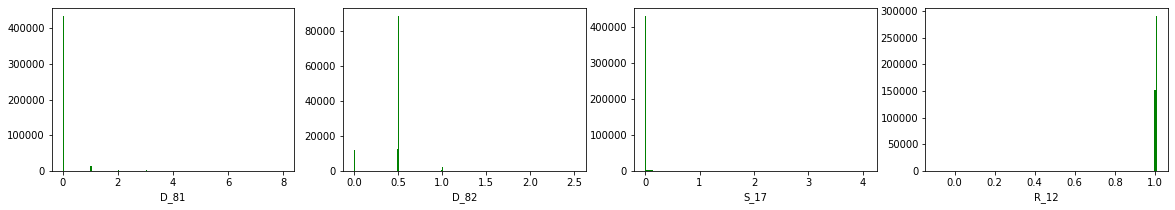

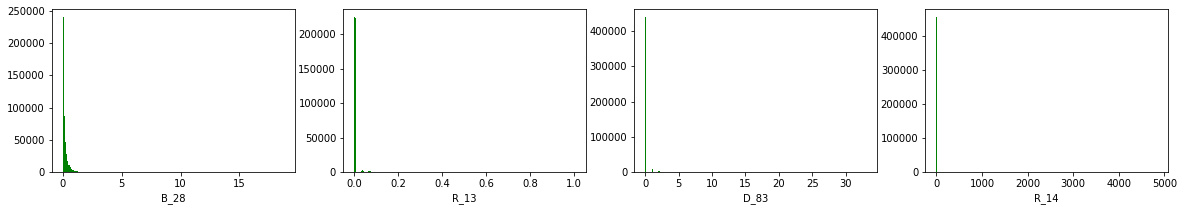

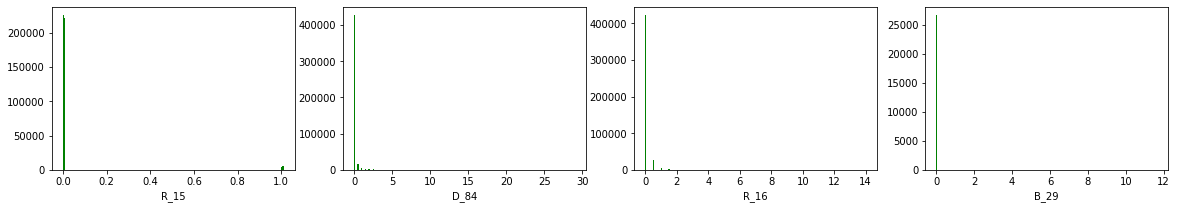

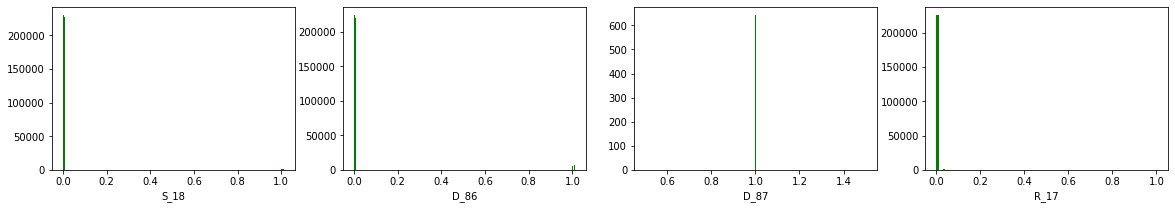

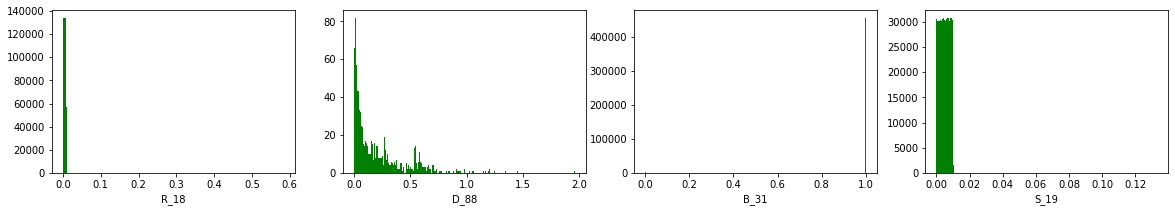

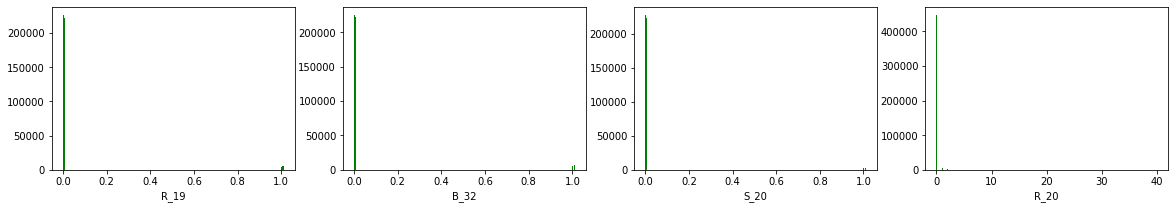

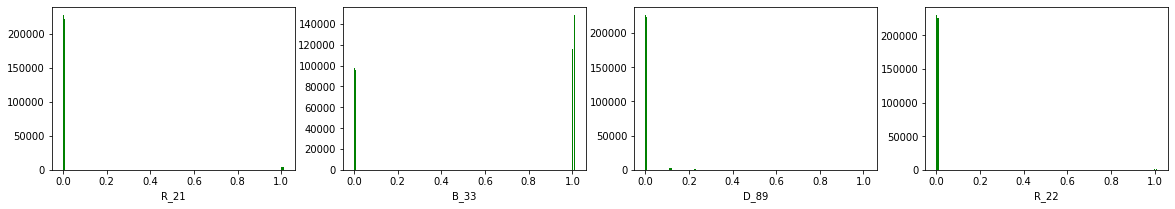

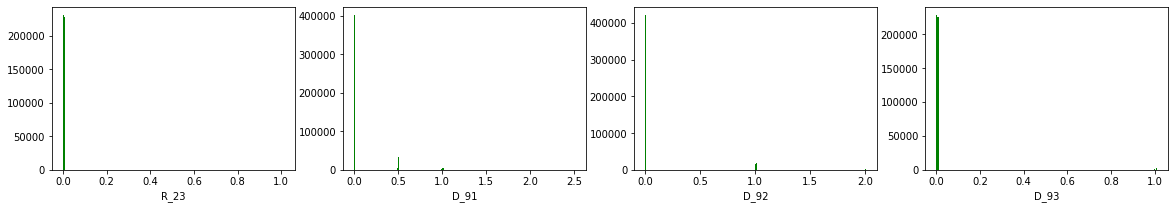

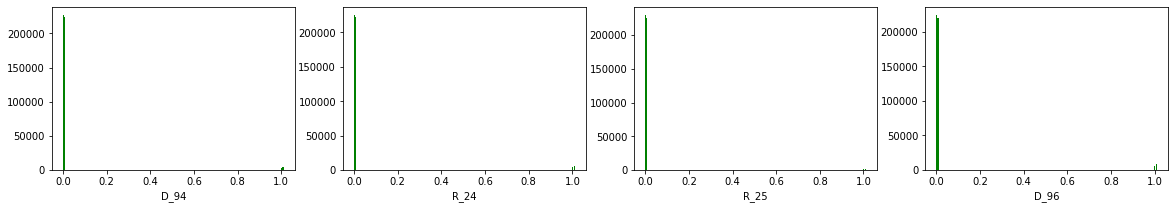

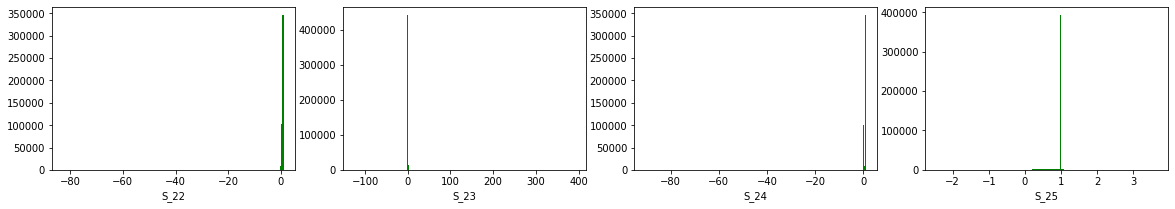

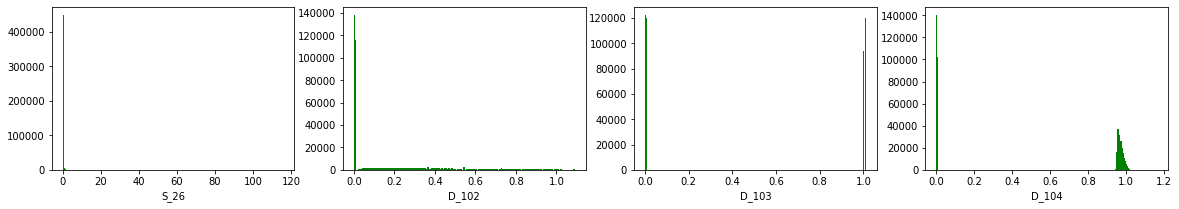

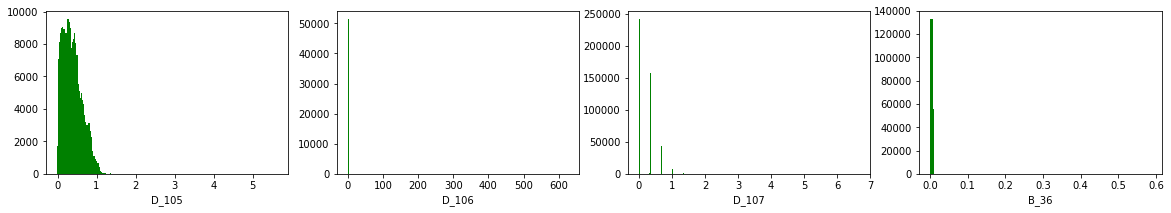

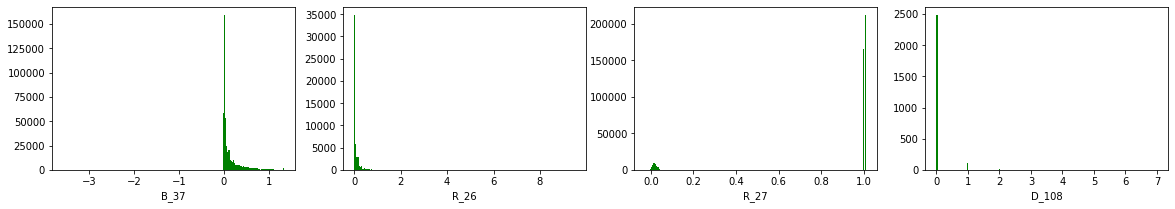

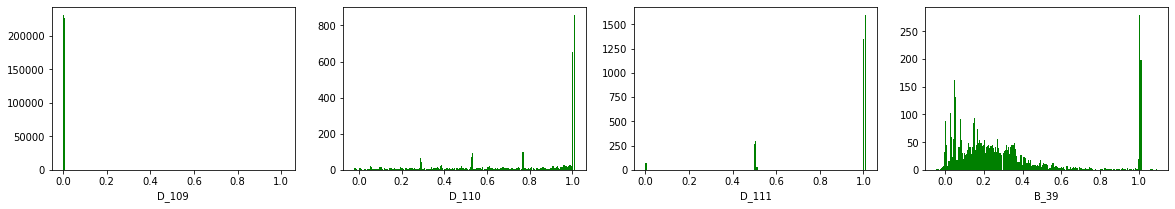

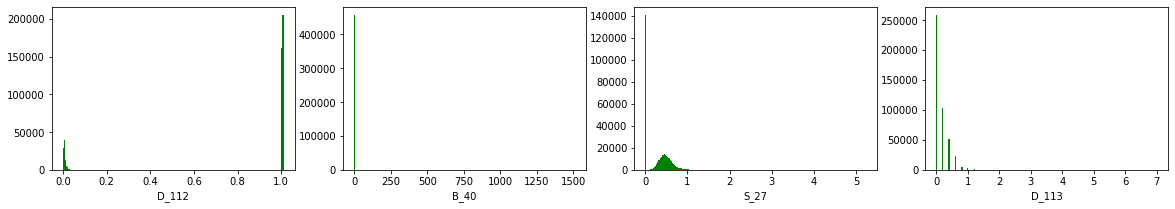

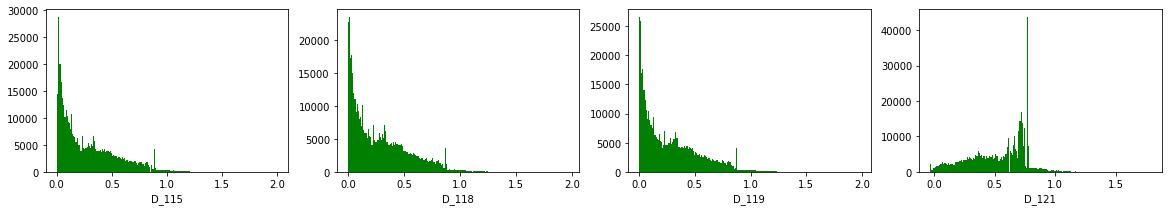

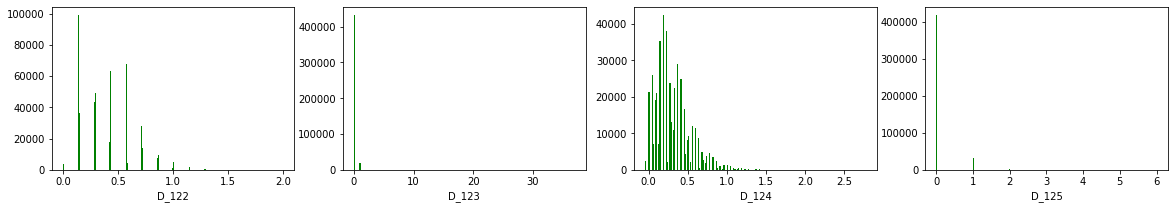

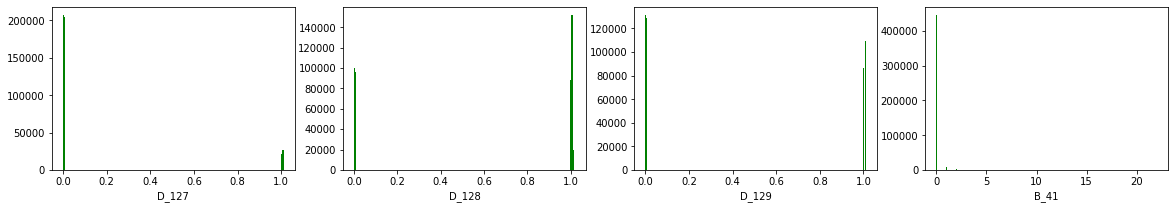

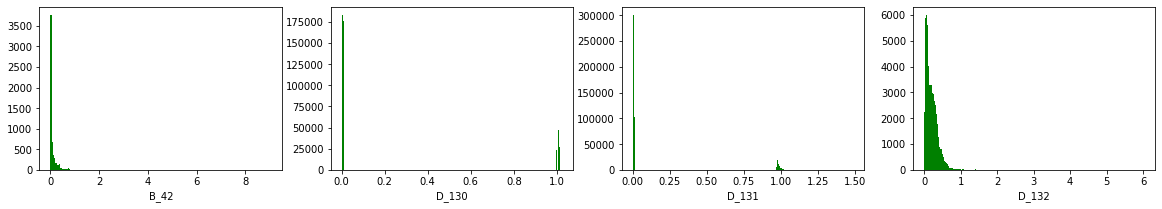

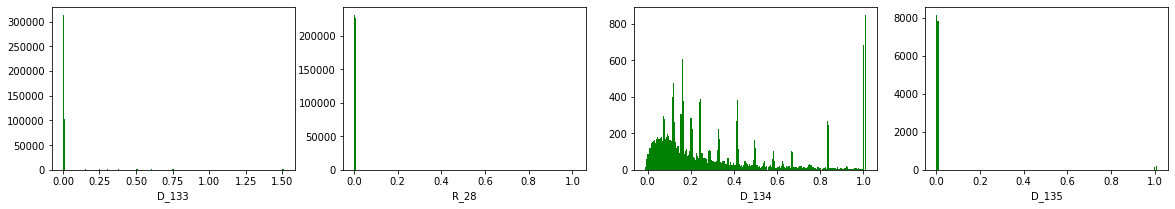

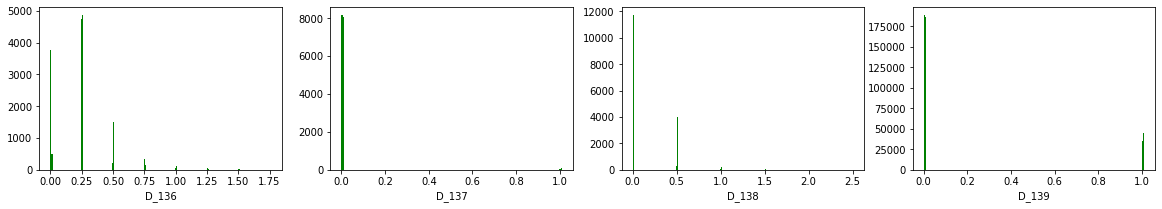

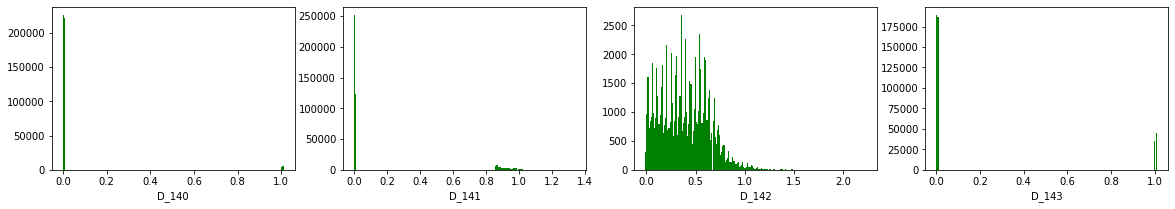

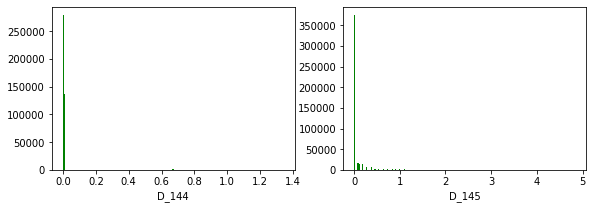

In [11]:
# Visualize non-categorial features
for i, l in enumerate(numerical_variables):
    if i % 4 == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(20, 3))
    plt.subplot(1, 4, i % 4 + 1)
    plt.hist(train_dataset[l], bins=200, color='#008000')
    plt.xlabel(l)
plt.show()

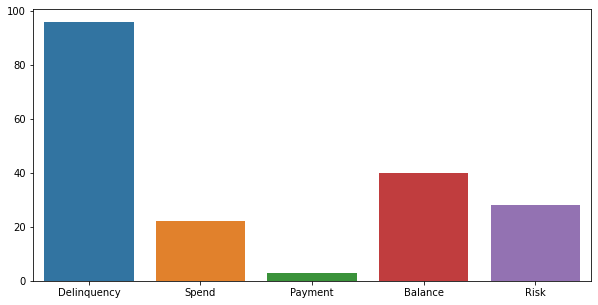

In [12]:
# Aggregated profile features
Delinquency = [d for d in train_dataset.columns if d.startswith('D_')]
Spend = [s for s in train_dataset.columns if s.startswith('S_')]
Payment = [p for p in train_dataset.columns if p.startswith('P_')]
Balance = [b for b in train_dataset.columns if b.startswith('B_')]
Risk = [r for r in train_dataset.columns if r.startswith('R_')]
Dict = {'Delinquency': len(Delinquency), 'Spend': len(Spend), 'Payment': len(Payment), 'Balance': len(Balance), 'Risk': len(Risk),}

plt.figure(figsize=(10,5))
sns.barplot(x=list(Dict.keys()), y=list(Dict.values()));

In [13]:
NaN_Val = np.array(train_dataset.isnull().sum())
NaN_prec = np.array((train_dataset.isnull().sum() * 100 / len(train_dataset)).round(2))
NaN_Col = pd.DataFrame([np.array(list(train_dataset.columns)).T,NaN_Val.T,NaN_prec.T,np.array(list(train_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)
NaN_Col

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,2969,0.65,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,31,0.01,float16
5,R_1,0,0.0,float16
6,S_3,84970,18.52,float16
7,D_41,31,0.01,float16
8,B_3,31,0.01,float16
9,D_42,399003,86.95,float16


In [14]:
# Drop variables with missing values >=70% in the train dataframe
i=0
for col in train_dataset.columns:
    if (train_dataset[col].isnull().sum()/len(train_dataset[col])*100) >=70:
        print("Dropping column", col)
        train_dataset.drop(labels=col,axis=1,inplace=True)
        i=i+1
        
print("Total number of columns dropped in train dataframe", i)

Dropping column D_42
Dropping column D_49
Dropping column D_53
Dropping column D_66
Dropping column D_73
Dropping column D_76
Dropping column R_9
Dropping column D_82
Dropping column B_29
Dropping column D_87
Dropping column D_88
Dropping column D_106
Dropping column R_26
Dropping column D_108
Dropping column D_110
Dropping column D_111
Dropping column B_39
Dropping column B_42
Dropping column D_132
Dropping column D_134
Dropping column D_135
Dropping column D_136
Dropping column D_137
Dropping column D_138
Dropping column D_142
Total number of columns dropped in train dataframe 25


In [15]:
train_dataset["S_2"] = train_dataset["S_2"].astype('datetime64[ns]')
train_dataset["Day of week"] = train_dataset["S_2"].dt.dayofweek
train_dataset["Year"] = train_dataset["S_2"].dt.year
train_dataset["Month"] = train_dataset["S_2"].dt.month
train_dataset["Day"] = train_dataset["S_2"].dt.day

In [16]:
train_dataset.drop(axis=1, columns=['S_2'], inplace=True)

In [17]:
selected_col = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for col in selected_col:
    train_dataset[col] = train_dataset[col].fillna(train_dataset[col].median())

In [18]:
selcted_col2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for col2 in selcted_col2:
    train_dataset[col2] =  train_dataset[col2].fillna(train_dataset[col2].mode()[0])

In [19]:
# Check null values again
print(train_dataset.isnull().sum().to_string())

P_2            0
D_39           0
B_1            0
B_2            0
R_1            0
S_3            0
D_41           0
B_3            0
D_43           0
D_44           0
B_4            0
D_45           0
B_5            0
R_2            0
D_46           0
D_47           0
D_48           0
B_6            0
B_7            0
B_8            0
D_50           0
D_51           0
B_9            0
R_3            0
D_52           0
P_3            0
B_10           0
S_5            0
B_11           0
S_6            0
D_54           0
R_4            0
S_7            0
B_12           0
S_8            0
D_55           0
D_56           0
B_13           0
R_5            0
D_58           0
S_9            0
B_14           0
D_59           0
D_60           0
D_61           0
B_15           0
S_11           0
D_62           0
D_63           0
D_64           0
D_65           0
B_16           0
B_17           0
B_18           0
B_19           0
B_20           0
D_68           0
S_12           0
R_6           

In [20]:
train_dataset.shape

(458913, 168)

In [21]:
train_dataset.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_140,D_141,D_143,D_144,D_145,target,Day of week,Year,Month,Day
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.092407,0.003258,...,0.004234,0.005085,0.005810,0.002970,0.008530,0,1,2018,3,13
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.060638,0.008781,...,0.007481,0.007874,0.003284,0.003170,0.008514,0,6,2018,3,25
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880859,0.009705,0.004284,0.812500,0.006451,0.164917,0.003796,0.007195,0.092407,0.000628,...,0.006622,0.000965,0.002201,0.000834,0.003445,0,0,2018,3,12
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.046112,0.007793,...,0.006184,0.001899,0.008186,0.005558,0.002983,0,3,2018,3,29
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.872070,0.005573,0.007679,0.815918,0.001247,0.164917,0.000231,0.005527,0.044678,0.002436,...,0.004162,0.005764,0.008156,0.006943,0.000905,0,4,2018,3,30


# Test Dataset

In [22]:
test_dataset = pd.read_feather('../input/amexfeather/test_data.ftr')
# Keep the latest statement features for each customer
test_dataset = test_dataset.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

In [23]:
test_dataset.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.10376,...,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,...,NaN,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,...,NaN,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,...,NaN,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,...,NaN,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525


In [24]:
test_dataset.shape

(924621, 189)

In [25]:
NaN_Val2 = np.array(test_dataset.isnull().sum())
NaN_prec2 = np.array((test_dataset.isnull().sum() * 100 / len(test_dataset)).round(2))
NaN_Col2 = pd.DataFrame([np.array(list(test_dataset.columns)).T,NaN_Val2.T,NaN_prec2.T,np.array(list(test_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

NaN_Col2

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,4784,0.52,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,43,0.0,float16
5,R_1,0,0.0,float16
6,S_3,144280,15.6,float16
7,D_41,43,0.0,float16
8,B_3,43,0.0,float16
9,D_42,827578,89.5,float16


In [26]:
test_dataset = test_dataset.drop(['D_42', 'D_49', 'D_53', 'D_66', 'D_73', 'D_76', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142'], axis=1)

In [27]:
test_dataset["S_2"] = test_dataset["S_2"].astype('datetime64[ns]')
test_dataset["Day of week"] = test_dataset["S_2"].dt.dayofweek
test_dataset["Year"] = test_dataset["S_2"].dt.year
test_dataset["Month"] = test_dataset["S_2"].dt.month
test_dataset["Day"] = test_dataset["S_2"].dt.day

In [28]:
test_dataset.drop(axis=1, columns=['S_2'], inplace=True)

In [29]:
selected_col = np.array(['P_2','S_3','B_2','S_12', 'S_17','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for col in selected_col:
    test_dataset[col] = test_dataset[col].fillna(test_dataset[col].median())

In [30]:
selcted_col2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for col2 in selcted_col2:
    test_dataset[col2] =  test_dataset[col2].fillna(test_dataset[col2].mode()[0])

In [31]:
# Check null values again
print(test_dataset.isnull().sum().to_string())

P_2            0
D_39           0
B_1            0
B_2            0
R_1            0
S_3            0
D_41           0
B_3            0
D_43           0
D_44           0
B_4            0
D_45           0
B_5            0
R_2            0
D_46           0
D_47           0
D_48           0
B_6            0
B_7            0
B_8            0
D_50           0
D_51           0
B_9            0
R_3            0
D_52           0
P_3            0
B_10           0
S_5            0
B_11           0
S_6            0
D_54           0
R_4            0
S_7            0
B_12           0
S_8            0
D_55           0
D_56           0
B_13           0
R_5            0
D_58           0
S_9            0
B_14           0
D_59           0
D_60           0
D_61           0
B_15           0
S_11           0
D_62           0
D_63           0
D_64           0
D_65           0
B_16           0
B_17           0
B_18           0
B_19           0
B_20           0
D_68           0
S_12           0
R_6           

In [32]:
test_dataset.shape

(924621, 167)

In [33]:
test_dataset.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_139,D_140,D_141,D_143,D_144,D_145,Day of week,Year,Month,Day
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.007397,0.006786,...,0.005913,0.001250,0.006542,0.009163,0.003691,0.003220,5,2019,10,12
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,0.096863,0.004234,...,0.004345,0.000866,0.009117,0.002197,0.000247,0.007778,0,2019,4,15
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,0.105286,0.003382,...,1.000977,0.008896,0.895996,1.009766,0.457764,0.092041,2,2019,10,16
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,0.211670,0.258545,...,1.007812,0.003754,0.919922,1.007812,0.500977,0.182983,0,2019,4,22
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,0.071899,0.375732,...,0.006622,0.001140,0.009529,0.009407,0.001557,0.000525,1,2019,10,22


In [34]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
categorical_variables.remove('D_66')

train_dataset[categorical_variables] = enc.fit_transform(train_dataset[categorical_variables])
test_dataset[categorical_variables] = enc.transform(test_dataset[categorical_variables])

In [35]:
train_dataset_without_target = train_dataset.drop(["target"],axis=1)

cor_matrix = train_dataset_without_target.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
col_core

{'B_11',
 'B_13',
 'B_15',
 'B_23',
 'B_33',
 'B_37',
 'D_104',
 'D_119',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

In [36]:
#train_dataset = train_dataset.drop(col_core, axis=1)
#test_dataset = test_dataset.drop(col_core, axis=1)

In [37]:
train_dataset.shape

(458913, 168)

In [38]:
num_columns = [col for col in train_dataset.columns if col not in ["target"]]

X = train_dataset[num_columns]
y = train_dataset['target']

print(f"X shape is = {X.shape}" )
print(f"Y shape is = {y.shape}" )

X shape is = (458913, 167)
Y shape is = (458913,)


In [39]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape is = {x_train.shape}" )
print(f"Y_train shape is = {y_train.shape}" )
print(f"X_test shape is = {x_test.shape}" )
print(f"Y_test shape is = {y_test.shape}" )

X_train shape is = (367130, 167)
Y_train shape is = (367130,)
X_test shape is = (91783, 167)
Y_test shape is = (91783,)


## LightGBM Classifier 

In [51]:
# Initialize the LightGBM Classifier
train_lightboost = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_variables)

params = {'objective': 'binary','n_estimators': 1250,'metric': 'binary_logloss','boosting': 'gbdt','num_leaves': 90,'reg_lambda' : 50,'colsample_bytree': 0.19,'learning_rate': 0.03,'min_child_samples': 2400,'max_bins': 511,'seed': 42,'verbose': -1}

# trained model with 100 iterations
model_lightboost = lgb.train(params, train_lightboost, 100)

In [52]:
# Test accuracy
predictions = model_lightboost.predict(x_test[num_columns])
roc_auc_score(y_test,predictions,average='macro')

0.9612670423683661

In [53]:
# Make predictions
predictions = model_lightboost.predict(test_dataset[num_columns])

In [54]:
# Save predictions of the LightGBM Classifier model to the submission csv

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('submission.csv', index=False)

## XGB Classifier

In [46]:
# Initialize the KNN Classifier
model_xgb = XGBClassifier(
    n_estimators = 10, 
    random_state = 5)

# Fit the model on the training data
model_xgb.fit(x_train, y_train, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=5,
              reg_alpha=0, reg_lambda=1, ...)

In [47]:
# Test accuracy
predictions = model_xgb.predict(x_test[num_columns])
roc_auc_score(y_test,predictions,average='macro')

0.8583870768401479

In [49]:
# Make predictions
predictions = model_xgb.predict(test_dataset[num_columns])

In [50]:
# Save predictions of the XGB Classifier model to the submission csv

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('submission.csv', index=False)

## SVM Classifier

In [ ]:
# Initialize the SVM Classifier
model_svm = SVC(kernel='rbf', random_state = 1)

# Fit the model on the training data
model_svm.fit(x_train, y_train)

In [ ]:
# Test accuracy
predictions = model_svm.predict(x_test[num_columns])
roc_auc_score(y_test,predictions,average='macro')

In [ ]:
# Make predictions
predictions = model_svm.predict(test_dataset[num_columns])

In [ ]:
# Save predictions of the SVM Classifier model to the submission csv

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('submission.csv', index=False)

## KNN Classifier

In [ ]:
# Initialize the KNN Classifier
model_knn = KNeighborsClassifier(n_neighbors = 5)

# Fit the model on the training data
model_knn.fit(x_train, y_train)

In [ ]:
# Test accuracy
predictions = model_knn.predict(x_test[num_columns])
roc_auc_score(y_test,predictions,average='macro')

In [ ]:
# Make predictions
predictions = model_knn.predict(test_dataset[num_columns])

In [ ]:
# Save predictions of the KNN Classifier model to the submission csv

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('submission.csv', index=False)

## CatBoost Classifier

In [41]:
# Initialize the CatBoost Classifier
model_catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=10, verbose=False)

# Fit the model on the training data
model_catboost.fit(x_train, y_train)

In [42]:
# Test accuracy
predictions = model_catboost.predict(x_test[num_columns])
roc_auc_score(y_test,predictions,average='macro')

0.8680859375747665

In [43]:
# Make predictions on the test data
predictions = model_catboost.predict(test_dataset[num_columns])

In [44]:
# Save predictions of the CatBoost Classifier model to the submission csv

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('submission.csv', index=False)